# The Kalman filter

The model below is taken from the [paper](https://link.springer.com/content/pdf/10.1007/s11222-019-09884-y.pdf), Section 5.3 with simplifications.

We consider the model in the paper, and the first part of this code concerns with data generation.

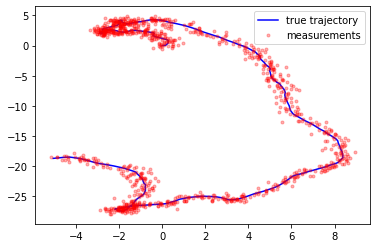

In [14]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(1234)

# define the linear system for object tracking
# x = [x, y, vx, vy]
T = 1000
x = np.zeros((4, T))
x[:, 0] = np.zeros(4)

k = 0.04

A = np.block([
    [np.eye(2), k * np.eye(2)],
    [np.zeros((2, 2)), 0.99 * np.eye(2)]
])

Q = np.block([
    [k**3 / 3 * np.eye(2), k**2 / 2 * np.eye(2)],
    [k**2 / 2 * np.eye(2), k * np.eye(2)]
])

H = np.array([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])

R = 0.1 * np.array([[1, 0.0], [0.0, 1]])

y = np.zeros((2, T))

for t in range(1, T):
    x[:, t] = A @ x[:, t-1] + rng.multivariate_normal(np.zeros(4), Q)
    y[:, t] = H @ x[:, t] + rng.multivariate_normal(np.zeros(2), R)

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.legend(['true trajectory', 'measurements'])


Next, as explained in the slides, we write our Kalman filtering functions.

In [16]:
def kalman_predict(mu, V, A, Q):
    mu_pred = A @ mu
    V_pred = A @ V @ A.T + Q
    return mu_pred, V_pred

def kalman_update(mu_pred, V_pred, H, R, y):
    S = H @ V_pred @ H.T + R
    K = V_pred @ H.T @ np.linalg.inv(S)
    mu = mu_pred + K @ (y - H @ mu_pred)
    V = V_pred - K @ H @ V_pred
    return mu, V

Next, we will run our filter - and compare the filter estimates to the ground truth signal.

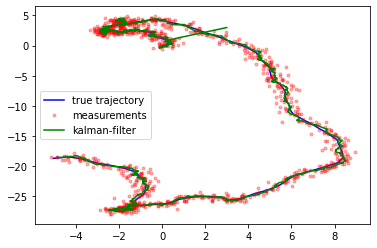

In [17]:

mu = np.zeros((4, T))
V = np.zeros((4, 4, T))

mu[:, 0] = np.ones(4) * 3
V[:, :, 0] = 10 * np.eye(4)

mu_pred = np.zeros((4, T))
V_pred = np.zeros((4, 4, T))

for t in range(1, T):
    mu_pred[:, t], V_pred[:, :, t] = kalman_predict(mu[:, t-1], V[:, :, t-1], A, Q)

    mu[:, t], V[:, :, t] = kalman_update(mu_pred[:, t], V_pred[:, :, t], H, R, y[:, t])

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.plot(mu[0, :], mu[1, :], 'g-')
plt.legend(['true trajectory', 'measurements', 'kalman-filter'])
plt.show()

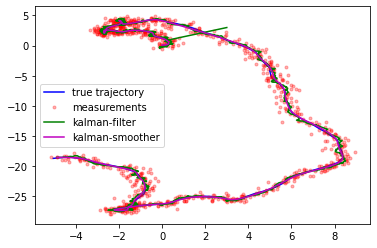

In [15]:
# Kalman smoother

mu_smooth = np.zeros((4, T))
V_smooth = np.zeros((4, 4, T))

mu_smooth[:, -1] = mu[:, -1]
V_smooth[:, :, -1] = V[:, :, -1]

for t in range(T-2, -1, -1):
    J = V[:, :, t].dot(A.T).dot(np.linalg.inv(V_pred[:, :, t+1]))
    mu_smooth[:, t] = mu[:, t] + J.dot(mu_smooth[:, t+1] - mu_pred[:, t+1])
    V_smooth[:, :, t] = V[:, :, t] + (J.dot(V_smooth[:, :, t+1] - V_pred[:, :, t+1])).dot(J.T)

plt.plot(x[0, :], x[1, :], 'b-')
plt.plot(y[0, :], y[1, :], 'r.', alpha=0.3)
plt.plot(mu[0, :], mu[1, :], 'g-')
plt.plot(mu_smooth[0, :], mu_smooth[1, :], 'm-')
plt.legend(['true trajectory', 'measurements', 'kalman-filter', 'kalman-smoother'])
plt.show()